In [30]:
%matplotlib inline

**Reference**: 
1. [Sean Robertson](https://github.com/spro/practical-pytorch)
2. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Note

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.


In [31]:
# from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
# import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
UNK_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name, sent_split = lambda sent: sent.split(' ')):
        self.sent_split = sent_split
        self.name = name
        self.word2count = {}
        self.index2word = {0: "<UNK>", 1: "<SOS>", 2: "<EOS>"}
        self.word2index = {ch:idx for idx,ch in self.index2word.items()}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in self.sent_split(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def sent2index(self,sent:str):
        words = self.sent_split(sent)
        indexes = tuple(self.word2index.get(word,UNK_token) for word in words)
        return indexes
    
    def index2sent(self,indexes:tuple[int]):
        words = [self.index2word.get(idx,'<UNK>') for idx in indexes]
        return ' '.join(words)
        

In [33]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [34]:
def parse_lang_file(path,reverse=False):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(path, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
    return pairs

In [35]:
def filter_pair(p):
    eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
    )
    return p[1].startswith(eng_prefixes)
        
def add_lang(input_lang:Lang, output_lang:Lang, path, reverse=False):
    pairs = parse_lang_file(path, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = [pair for pair in pairs if filter_pair(pair)]
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang = Lang('fra')
output_lang = Lang('eng')

input_lang, output_lang, pairs = add_lang(input_lang,output_lang,path = 'data/eng-fra.txt', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 13067 sentence pairs
Counting words...
Counted words:
fra 5172
eng 3390
['je suis sur que tu es tres occupee .', 'i m sure you re very busy .']


In [36]:
def preprocessing_pairs(lang1:Lang,lang2:Lang,pairs):
    return [(lang1.sent2index(p),
             lang2.sent2index(q))
            for p,q in pairs]

def partition_by_len(pairs,):
    res = {}
    for p,q in pairs:
        key = (len(p),len(q))
        
        if key not in res:
            res[key] = []
        
        res[key].append((p,q))
    return list(res.values())

def filter_pairs(pairs,min_size = 64,min_len = 5):
    partitions = partition_by_len(pairs)
    fufillment_cond = lambda *qs : all(len(q) > min_len for q in qs)
    return [partition for partition in partitions 
            if len(partition) >= min_size and fufillment_cond(*partition[0])]

def make_datasets(partitioned_pairs,test_size=0.3):
    from torch.utils.data import TensorDataset,DataLoader
    from sklearn.model_selection import train_test_split
    train_datasets,test_datasets = [],[]
    for pairs in partitioned_pairs:
        X,y = [],[]
        for (p,q) in pairs:
            X.append(p)
            y.append(q)
        X = torch.tensor(X)
        y = torch.tensor(y)
        Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=test_size,random_state=12345)
        train_dataset = DataLoader(TensorDataset(Xtr,ytr),batch_size=32)
        test_dataset = DataLoader(TensorDataset(Xte,yte),batch_size=32)
        train_datasets.append(train_dataset)
        test_datasets.append(test_dataset)
    return train_datasets,test_datasets

partitioned_pairs = filter_pairs(preprocessing_pairs(input_lang,output_lang,pairs),min_len=0)
train_datasets,test_datasets = make_datasets(partitioned_pairs,0.3)

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [37]:
class Encoder_RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size,num_layers=1):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        super(Encoder_RNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size,num_layers=num_layers,batch_first = True)

    def forward(self, x, hidden=None):
        # (N, seq_len, 1)
        x = x.reshape(x.size(0),-1)     # (N, seq_len)
        embedded = self.embedding(x)    # (N,seq_len,hidden_size)
        # output - (N,seq_len,hidden_size)
        # hidden - (num_layers,N,hidden_size)
        output, hidden = self.gru(embedded, hidden) 
        return output, hidden

    def init_hidden(self,batch_size=1):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)
    
    @property
    def ctor_kwargs(self):
        return {
            "vocab_size" : self.vocab_size,
            "hidden_size": self.hidden_size,
            "num_layers" : self.num_layers,
        }

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the *context vector* as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string ``<SOS>`` token, and the first hidden state is the context vector (the encoder's last hidden state).

In [38]:
class Decoder_RNN(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers=1):
        super(Decoder_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size,num_layers=num_layers ,batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=2),
        )
    
    
    def forward(self, x, hidden = None):
        # x - (N,seq_len,1) or (1,seq_len,1)
        x = x.reshape(x.size(0),-1)  # (N,seq_len)
        embedded = self.embedding(x) # (N,seq_len,hidden_size)
        embedded = F.relu(embedded)
        
        output, hidden = self.gru(embedded, hidden)
        output = self.out(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        num_layers = self.gru.num_layers
        return torch.zeros(num_layers, batch_size, self.hidden_size, device=device)

    @property
    def ctor_kwargs(self):
        return {
            "hidden_size":self.hidden_size,
            "output_size":self.output_size,
            "num_layers" : self.num_layers,
        }
        

# Attention
## Self-Attention
- X - (see,**that**,girl,run)
- x - **that**
- Q - x
- K - X
- V - X
- Self_Attention (Q,K,V) = Revelance(Q,K) * V
## seq2seq
- Attention(Q = Input, K = Prev_Hidden, V = Encoder_Hidden)

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Type of attention:
- Bahdanau attention
- Luong attention

In [546]:
class Bahdanau_Decoder(nn.Module):
    def __init__(self,hidden_size,output_size,num_layers=1,drop_prob=0.1):
        super(Bahdanau_Decoder,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob

        self.embedding = nn.Sequential(
            nn.Embedding(output_size,hidden_size),
            # nn.Dropout(drop_prob),
        )
        self.fc_hidden = nn.Linear(hidden_size,hidden_size,bias=False)
        self.fc_encoder = nn.Linear(hidden_size,hidden_size,bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(hidden_size))
        self.attn_combine = nn.Linear(hidden_size*2,hidden_size)
        self.rnn = nn.GRU(hidden_size*2,hidden_size,num_layers=num_layers,batch_first = True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size,output_size),
            nn.LogSoftmax(dim=2),
        )
    @property
    def ctor_kwargs(self):
        return {
            "hidden_size"   : self.hidden_size,
            "output_size"   : self.output_size,
            "num_layers"    : self.num_layers,
            "drop_prob"     : self.drop_prob,
        }

    def forward(self,inputs,hidden,encoder_outputs):
        embedded = self.embedding(inputs)
        
        key = self.fc_encoder(encoder_outputs)
        query = self.fc_hidden(hidden[-1]).unsqueeze(1)
        
        # Calculating Alignment Scores
        x = torch.tanh(query + key)
        alignment_scores = torch.bmm(x,self.weight.unsqueeze(0).repeat(x.size(0),1).unsqueeze(-1))
        alignment_scores = alignment_scores.view(x.size(0),-1)
        # Softmaxing alignment scores to get Attention weights
        attn_weights = F.softmax(alignment_scores, dim=1)
        
        # Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs).view(inputs.size(0),self.hidden_size)
        
        output = torch.cat((embedded, context_vector.unsqueeze(1).repeat(1,inputs.size(1),1)), -1)
        output, hidden = self.rnn(output, hidden)
        
        output = self.classifier(output)
        return output, hidden, attn_weights

In [547]:
def one_pass():
    criterion = nn.CrossEntropyLoss()
    X,Y = next(iter(train_datasets[0]))
    
    encoder = Encoder_RNN(input_lang.n_words,10,2)
    
    # encoder pass
    encoder_out,encoder_hidden = encoder(X,encoder.init_hidden(X.size(0)))
    
    # decoder pass v1
    Y = F.pad(Y,(0,1,0,0),value=EOS_token)
    decoder = Bahdanau_Decoder(10,output_lang.n_words,2)
    loss = 0
    decoder_input = torch.tensor([[SOS_token] * Y.size(0)]).transpose(0,1)  # Shape: (N,1)
    decoder_hidden = encoder_hidden
    for t in range(Y.size(1)):
        # decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
        decoder_output, decoder_hidden,*_ = decoder(decoder_input,decoder_hidden,encoder_out)
        loss += criterion(decoder_output.reshape(decoder_output.size(0),-1),Y[:,t])
        decoder_input = Y[:,[t]]
        break
    
    return decoder_output.shape,decoder_hidden.shape,loss
one_pass()

(torch.Size([32, 1, 3390]),
 torch.Size([2, 32, 10]),
 tensor(8.0012, grad_fn=<AddBackward0>))

# SEQ2SEQ and Attention

reference : https://youtu.be/OyFJWRnt_AY
 

Components
- queries, Q
- keys, K
- values, V

Translation Task and QKV
1. Q - hidden state of output word
2. K - hidden state of input word
3. V - hidden state of input word

Process

$$
e = Q \cdot K \\
\alpha = softmax(e)\\
attention(Q,K,V) =\alpha \cdot V = softmax(Q\cdot K)\cdot V \\
attention(Q,K,V) = similarity(Q,K)\cdot V
$$
The learnable component is the activation function $softmax$.

## Training

In [548]:
def train(encoder:Encoder_RNN,decoder:Decoder_RNN|Bahdanau_Decoder,
          dataset,optimzer,criterion):
    encoder.train()
    decoder.train()
    loss_hist = []
    for X,Y in dataset:
        X,Y = X.to(device),Y.to(device)
        
        # encoder pass
        encoder_outputs,encoder_hidden = encoder(X,encoder.init_hidden(X.size(0)).to(device))
        
        # decoder pass
        Y = F.pad(Y,(0,1,0,0),value=EOS_token)
        loss = 0
        
        # Shape: (N,1)
        decoder_input = torch.tensor([[SOS_token] * Y.size(0)],device=device).transpose(0,1)
        decoder_hidden = encoder_hidden
        for t in range(Y.size(1)):
            # decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
            decoder_output, decoder_hidden,*_ = decoder(decoder_input,decoder_hidden,encoder_outputs)
            loss += criterion(decoder_output.reshape(decoder_output.size(0),-1),Y[:,t])
            decoder_input = Y[:,[t]]
        
        # backward pass
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()
        loss_hist.append(loss.item())
    return loss_hist

In [549]:
def test(encoder:Encoder_RNN,decoder:Decoder_RNN|Bahdanau_Decoder,
         dataset,criterion):
    encoder.eval()
    decoder.eval()
    loss_hist = []
    with torch.no_grad():
        for X,Y in dataset:
            X,Y = X.to(device),Y.to(device)
            
            # encoder pass
            encoder_outputs,encoder_hidden = encoder(X,encoder.init_hidden(X.size(0)).to(device))
            
            # decoder pass
            Y = F.pad(Y,(0,1,0,0),value=EOS_token)
            loss = 0
            
            # Shape: (N,1)
            decoder_input = torch.tensor([[SOS_token] * Y.size(0)],device=device).transpose(0,1)
            decoder_hidden = encoder_hidden
            for t in range(Y.size(1)):
                # decoder_output, decoder_hidden = decoder(decoder_input,decoder_h)
                decoder_output, decoder_hidden,*_ = decoder.forward(decoder_input,decoder_hidden,encoder_outputs)
                loss += criterion(decoder_output.reshape(decoder_output.size(0),-1),Y[:,t])
                decoder_input = Y[:,[t]]
            
            loss_hist.append(loss.item())
    return loss_hist

In [550]:
def plot_loss(train_hist,test_hist):
    plt.title(f'epoch - {len(train_hist)}')
    plt.plot(train_hist,label='train')
    plt.plot(test_hist,label='test')
    plt.legend()
    plt.show()

In [557]:
def init(enc_ctor,dec_ctor,model_checkpoint_pth):
    hidden_size = 216
    max_lr = 0.1
    encoder = enc_ctor(input_lang.n_words, hidden_size,1).to(device)
    decoder = dec_ctor(hidden_size, output_lang.n_words,1).to(device)
    optimizer = optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=max_lr)
    init_checkpoint = {
        'device'            : device,
        'max_lr'            : max_lr,
        'encoder kwargs'    : encoder.ctor_kwargs,
        'decoder kwargs'    : decoder.ctor_kwargs,
        'encoder'           : encoder.state_dict(), # big
        'decoder'           : decoder.state_dict(), # big
        'optimzer'          : optimizer.state_dict(),
        'train_loss_hist'   : [],
        'test_loss_hist'    : [],
    }
    torch.save(init_checkpoint,model_checkpoint_pth)

def load(enc_ctor,dec_ctor,model_checkpoint_pth,force_init=False):
    import os
    if not os.path.exists(model_checkpoint_pth) or force_init:
        init(enc_ctor,dec_ctor,model_checkpoint_pth)
    checkpoint = torch.load(model_checkpoint_pth,map_location=device)
    
    encoder = enc_ctor(**checkpoint['encoder kwargs']).to(device)
    decoder = dec_ctor(**checkpoint['decoder kwargs']).to(device)
    
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    
    optimizer = optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=checkpoint['max_lr'])
    optimizer.load_state_dict(checkpoint['optimzer'])
    
    train_loss_hist = checkpoint['train_loss_hist']
    test_loss_hist = checkpoint['test_loss_hist']
    
    return encoder,decoder,optimizer,train_loss_hist,test_loss_hist

def save_checkpoint(encoder,decoder,optimizer,
                    train_loss_hist,test_loss_hist,
                    model_checkpoint_pth):
    checkpoint = torch.load(model_checkpoint_pth,map_location=device)
    new_checkpoint_values = {
        'encoder'           : encoder.state_dict(),
        'decoder'           : decoder.state_dict(),
        'optimizer'         : optimizer.state_dict(),
        'train_loss_hist'   : train_loss_hist,
        'test_loss_hist'    : test_loss_hist,
    }
    for k,v in new_checkpoint_values.items():
        checkpoint[k] = v
    torch.save(checkpoint,model_checkpoint_pth)

In [558]:
criterion = nn.CrossEntropyLoss()
train_size = sum(len(dataset.dataset) for dataset in train_datasets)
test_size = sum(len(dataset.dataset) for dataset in test_datasets)
model_checkpoint_pth = 'model_checkpoint/seq2seq_RNN_bahdanau_small.pth'
encoder,decoder,optimizer,train_loss_hist,test_loss_hist = load(Encoder_RNN,Bahdanau_Decoder,model_checkpoint_pth)

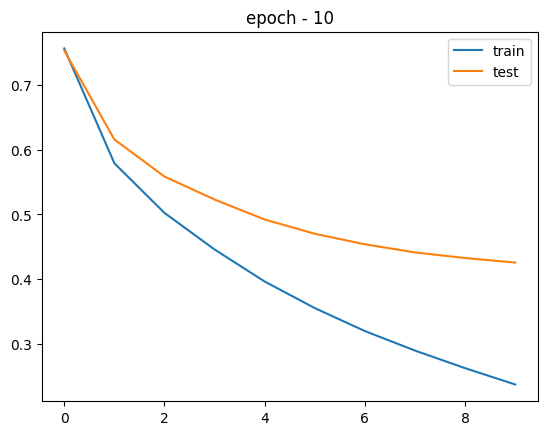

In [559]:
def train_iter(n = 10):    
    for i in range(n):
        train_loss = 0
        test_loss = 0
        for train_dataset,test_dataset in zip(train_datasets,test_datasets):
            train_losses = train(encoder,decoder,train_dataset,
                optimizer,criterion)
            test_losses = test(encoder,decoder,test_dataset,criterion)
            train_loss += sum(train_losses)
            test_loss += sum(test_losses)
        # don't forget to normalize the sum loss
        train_loss_hist.append(train_loss/train_size)
        test_loss_hist.append(test_loss/test_size)
        clear_output()
        plot_loss(train_loss_hist,test_loss_hist)
    save_checkpoint(encoder,decoder,optimizer,train_loss_hist,test_loss_hist,model_checkpoint_pth)
train_iter()

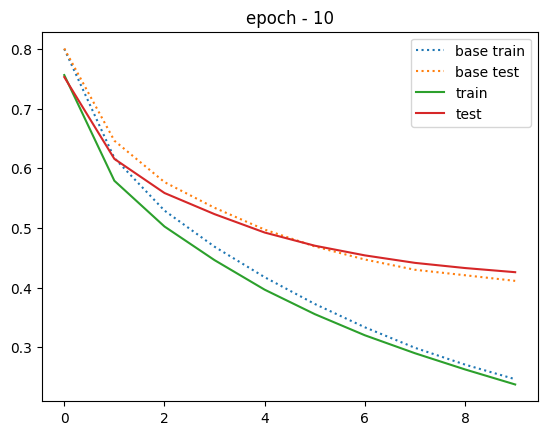

In [560]:
def fn():
    *_,train_loss_hist,test_loss_hist = load(Encoder_RNN,Decoder_RNN,'model_checkpoint/seq2seq_RNN_small.pth')
    plt.title(f'epoch - {len(train_loss_hist)}')
    plt.plot(train_loss_hist,label='base train',linestyle=':')
    plt.plot(test_loss_hist,label='base test',linestyle=':')
    *_,train_loss_hist,test_loss_hist = load(Encoder_RNN,Bahdanau_Decoder,model_checkpoint_pth)
    plt.plot(train_loss_hist,label='train')
    plt.plot(test_loss_hist,label='test')
    plt.legend()
    plt.show()
fn()

In [561]:
def predict(seq,encoder:Encoder_RNN,decoder:Decoder_RNN,MAX_LEN = 10):
    with torch.no_grad():
        seq = seq.to(device).reshape(1,-1)
        encoder_outputs,encoder_hidden = encoder(seq,encoder.init_hidden().to(device))
        
        decoder_hidden = encoder_hidden
        cur_tkn = torch.tensor([[SOS_token]],device=device)
        Y = []
        while cur_tkn.item() != EOS_token and len(Y) < MAX_LEN:
            # decoder_output,decoder_hidden = decoder(cur_tkn,decoder_hidden)
            decoder_output, decoder_hidden,*_ = decoder.forward(cur_tkn,decoder_hidden,encoder_outputs)
            # cur_tkn[0] = decoder_out.squeeze().exp().argmax()
            cur_tkn[0] = decoder_output.squeeze().argmax()
            Y.append(cur_tkn.item())
              
    return Y


In [562]:
# def visualize_attention(attn,input_sent,out_sent):
#     fig,ax = plt.subplots(1,1,figsize=(10,10))
#     ax.imshow(attn.detach().cpu(),cmap='gray')
#     # Show label at every tick
#     ax.set_yticks(range(len(out_sent)))
#     ax.set_xticks(range(len(input_sent)))
#     ax.set_yticklabels([output_lang.index2word.get(n,'<UNK>') for n in out_sent])
#     ax.set_xticklabels([input_lang.index2word.get(n,'<UNK>') for n in input_sent.detach().numpy()])
#     plt.show()

In [563]:
def fn(datasets, n = 3):
    encoder,decoder,*_ = load(Encoder_RNN,Bahdanau_Decoder,model_checkpoint_pth)
    for _ in range(n):
        idx = random.choice(range(len(datasets)))
        dataset = datasets[idx]
        input_sent,target = next(iter(dataset))
        
        idx = random.choice(range(len(input_sent)))
        input_sent,target = input_sent[idx],target[idx]
        out_sent = predict(input_sent,encoder,decoder,MAX_LEN = 100)
        
        print('---')
        print("input :", input_lang.index2sent(input_sent.detach().numpy()))
        print("output :",output_lang.index2sent(target.detach().numpy()))
        print("translate :" ,output_lang.index2sent(out_sent))
        # visualize_attention(attn,input_sent,out_sent)
        # print("output :",output_lang.index2sent(target.detach().numpy()))

fn(test_datasets)

---
input : c est mon ami . le connaissez vous ?
output : he s my friend . do you know him ?
translate : you re the one who should be thanking . <EOS>
---
input : nous n allons pas vous repondre .
output : we re not going to do it .
translate : we re not going to make it are you ? <EOS>
---
input : j ai un programme vraiment charge cette semaine .
output : i m on a really tight schedule this week .
translate : i m very sorry but a lot of mine . <EOS>
